In [26]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import json
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

# Homework 3

## Problem 1: BatchNorm

- Discuss the pros and cons of using BatchNorm. When does BatchNorm fail? Discuss alternatives and their pros and cons. What properties would an ideal normalization method have?

BatchNorm is used to improve the performance and training of neural networks. It is a type of normalization that normalizes the activations of each layer in a neural network to have zero mean and unit variance over a small sample size (mini-batch).

Batch Normalization has multiple advantages. It makes the training process faster: by stabilizing the distribution of the input, the computations are more stable and significantly faster. Without it (if the input was not normalized), the weights would have to constantly adjust to a new input distribution every time which makes the training very slow. So by using batch normalization, it is possible to use higher learning rate and accelerate the convergence of the network to reach optimal weights.
On the other hand, BatchNormalization prevents overfitting by acting like a regularization as it normalizes the activation functions and leads to the model performing better generalization. Finally, using BatchNormalization leads to the model having a higher accuracy and therefore improving the overall performance of the model.

However, BatchNormalization also presents some disadvantages. One disadvantage is that using batch normalization incurs the use of additional hyper parameters such as momentum and epsilon. These new hyper parameters lead to additional steps in reaching an optimal result as they will have to be tuned properly to find the right values. Also, if the batch size is very small, Batch Normalization may not be as effective as it relies on estimating the statistics from the mini-batch (which can be noisy with small batch sizes), this leads to poor performance. Similarly, if the mini batch is too large, the performance of the network is reduced as normalizing a large mini-batch may not represent the true distribution of the data. Thus, finding the right batch-size is very important.
BatchNormalization may fail when used with small datasets as it can lead to overfitting the training set and not generalize well the test set. It can also fail when used with RNNs, or when used with input with high dimensionality. Instead using other normalization or regularization techniques may be better. For instance, layer normalization normalizes the activations of each neuron in a layer rather than normalizing the activations over a mini-batch, this is better for RNNs and high dimensional inputs, however this technique is computationally expensive. Additionally, group normalization is another alternative that divides the channels of each layer into groups and normalizes each of these groups. This method is efficient for small batch sizes and large channel dimensions. However, it requires the number of channels to be able to be divided by the number of elements in the group. Instance normalization is another example, it normalizes the activation of each sample in a mini-batch which is useful for some image-based tasks. This method is also compatible with small batch sizes. However, it is only applicable to tasks where the entire input can be normalized in the same way, making it not very flexible. Finally, weight normalization normalizes the weights which can help stabilize training, improve generalization and requires less memory. However, weight normalization is more computationally expensive as the weights are normalized at each iteration. Plus, this method may not be applicable or interpretable to all types of neural networks or architectures.

An ideal normalization method would have low computational costs: training faster and outputting good performances. Also, it would be insensitive to batch size (such that it would give good performance with any batch size, small or large), and would be able to be incorporated within different neural network model architectures (CNNs, RNNs, etc.). Moreover, an ideal normalization would be flexible and be able to normalize different data types (images, text, audio, etc) and would perform well on any dataset size.

## Problem 2: Using a Pre-Trained CNN
For this problem you will use a CNN that has been trained on ImageNet-1k. You may use any pre-trained architecture developed from 2014 onwards (e.g., not AlexNet, but a VGG or ResNet model would be fine). The CNN needs to produce d-dimensional embeddings that are fed into the 1000-way output layer, where d is typically 512, 2048, or 4096. You will be re-using the CNN you select in the next problem for transfer learning with embeddings.

### Part 1 - Using Pre-Trained Deep CNN
I have used ResNet-50
Run it on peppers.jpg. Output the top-3 predicted categories and the probabilities. State the pre-trained CNN model that you used.
Make sure to pre-process the input image appropriately. Look at the toolbox documentation for the pre-trained model you use to determine how to do this.

In [27]:
#get pretrained ResNet-50 model and set it to evaluation mode
model = models.resnet50(pretrained=True)
model.eval()

#transformation pipeline to make input image usable by the model
transform = transforms.Compose([
    transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load and preprocess input image (transform using pipeline and add dimension) 
img = Image.open("/Users/aya/Desktop/DL/peppers.jpg")
img = transform(img).unsqueeze(0)
#print(img.shape)

#pass image through the model and get predictions
#torch.set_grad_enabled(False)
with torch.no_grad():
    outputs = model(img)
    _, pred = torch.topk(outputs, k=3)
#print(outputs.shape, pred.shape)

#load class names for ImageNet dataset
classes = json.load(open("/Users/aya/Desktop/DL/imagenet-simple-labels.json", "r"))

#top 3 predictions and their probabilities
for i in range(3):
    class_idx = pred[0][i]
    class_prob = torch.nn.functional.softmax(outputs, dim=1)[0][class_idx]
    class_name = classes[class_idx]
    print(f"Prediction {i+1}: {class_name} (predicted with probability {class_prob:.2f})")


Prediction 1: bell pepper (predicted with probability 0.99)
Prediction 2: cucumber (predicted with probability 0.01)
Prediction 3: grocery store (predicted with probability 0.00)


Hook activated
torch.Size([1, 64, 128, 171])
torch.Size([64, 128, 171])


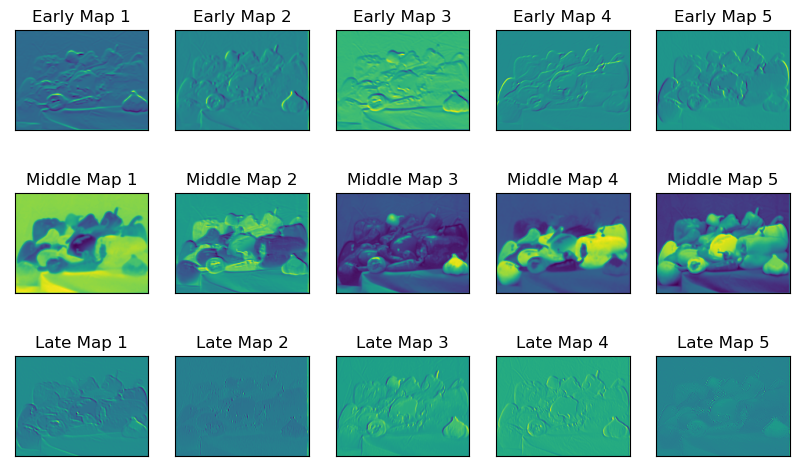

In [28]:
all_modules = [m for m in model.modules()]
#print((all_modules))
conv_modules = [m for m in all_modules if isinstance(m, torch.nn.Conv2d)]
#print(len(conv_modules))
#print(conv_modules[0])

saved_outputs = []
def save_out(module, input, output):
    print('Hook activated')
    saved_outputs.append(output)

#torch.nn.modules.module.register_module_forward_hook(save_out)
#conv_modules[-1].register_forward_hook(hook)
conv_modules[0].register_forward_hook(save_out)

with torch.no_grad():
    outputs = model(img)
print(saved_outputs[0].shape)
activations = saved_outputs[0][0]

#normalize values in each feature map to make them between 0 and 1
min_a, max_a = activations.min(), activations.max()
activations = (activations - min_a) / (max_a - min_a)
        
print(activations.shape)        
#set feature maps from early, middle and late layers
early_maps = [activations[3], activations[5], activations[9], activations[10], activations[12]]
middle_maps = [activations[29], activations[31], activations[32], activations[35], activations[40]] 
late_maps = [activations[45], activations[46], activations[55], activations[60], activations[63]]
#activations[55], activations[60]
#activations[50], activations[61]

#plot the feature maps
fig = plt.figure(figsize=(10, 6))
#early maps
for i in range(len(early_maps)):
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(early_maps[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Early Map {i+1}')
#middle maps
for i in range(len(middle_maps)):
    ax = fig.add_subplot(3, 5, i+6)
    ax.imshow(middle_maps[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Middle Map {i+1}')
#late maps
for i in range(len(late_maps)):
    ax = fig.add_subplot(3, 5, i+11)
    ax.imshow(late_maps[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Late Map {i+1}')

plt.show()


- Display feature maps and discuss their structure. Find some that are interpretable, and discuss the challenges in doing so.

In early layers, we can see that the feature maps have simple patterns (commonly knows as low-level features), they capture the edges around the peppers, defining the peppers' boundaries. The edge detection delimiting the shape of the peppers are represented by sudden changes in intensity of color in the image.

In the middle layers, we can observe more complex patterns and can see the bell peppers more clearly, differentiating between different parts of the object (the peppers) and their structure. For example, we can actually see the stem of the peppers, their body and the color variations. We can also clearly identify the size and shape of each pepper, we can differentiate the different type of peppers (by their color), we can see the surface on which they are, the arrangement of these pappers and their orientation on this surface. All of these features are detected within the middle layer.

Finally in the late layers, we observe feature maps that are more abstract which is harder to interpret. Nonetheless, we can see that the filters are slightly more focused on detecting the corner of the peppers (especially in late map 2 and 5) which represent the relationships between the different objects (peppers) of the image. Late map 1, 2 and 5 look like it is trying to highlight variations on the surface of the peppers which may be important for differentiating different pepper varieties or conditions.

##### Sources:
- https://pytorch.org/vision/stable/models.html
- ChatGPT, StackExchange, StackOverflow
- https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ 
- https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data
- https://wandb.ai/shweta/Activation%20Functions/reports/Activation-Functions-Compared-With-Experiments--VmlldzoxMDQwOTQ#the-mish-activation-function
- In-class MNIST Tutorial (google colab), CIFAR Tutorial
- https://pytorch.org/docs/stable/generated/torch.linalg.norm.html#torch.linalg.norm
- https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739